In [202]:
import skimage
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras


In [203]:
@tf.py_function(Tout=float)
def rgb2lab_tensor(img):
    img_numpy = img.numpy()
    img_numpy /= 255 # TODO : bouger la normalisation ailleurs
    img_lab = skimage.color.rgb2lab(img_numpy)
    return  tf.convert_to_tensor(img_lab)

In [204]:
train, test = keras.utils.image_dataset_from_directory(
    "my_celebs",
    labels=None,
    validation_split=0.2,
    subset="both",
    seed=1,
    image_size=(128, 128),
)

Found 33062 files.
Using 26450 files for training.
Using 6612 files for validation.


In [205]:
def preparer_dataset(dataset):
    batch_size = 32
    dataset_lab = dataset.unbatch().map(rgb2lab_tensor).batch(batch_size)
    dataset_separe = dataset_lab.map(lambda x: (tf.ensure_shape(x[:, :, :, 0], [batch_size, 128,128]),
                                                tf.ensure_shape(x[:, :, :, 1:], [batch_size, 128,128,2])))
    return dataset_separe

In [206]:
train_separe = preparer_dataset(train)
test_separe = preparer_dataset(test)

In [207]:
elem = next(iter(train_separe))
elem[0]

<tf.Tensor: shape=(32, 128, 128), dtype=float32, numpy=
array([[[100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        ...,
        [ 38.982983  ,  56.11155   ,  69.31203   , ...,  73.84509   ,
          96.03551   ,  98.51557   ],
        [ 40.440533  ,  39.766243  ,  59.905014  , ...,  76.74685   ,
          83.18629   ,  99.29625   ],
        [ 39.098568  ,  38.134922  ,  39.476437  , ...,  51.930634  ,
          74.882645  ,  96.304146  ]],

       [[ 96.35123   ,  96.21912   ,  96.12572   , ...,  99.60557   ,
          99.25889   ,  98.67038   ],
        [ 95.93815   ,  96.11972   ,  96.248     , ...,  99.59748   ,
          98.90543   ,  98.38809   ],
        [ 95.59597   ,  95.70119   ,  95.77551   , ...,  99.59134

In [208]:
reseau = keras.Sequential(
    [
        keras.Input((128, 128)),
        keras.layers.Reshape((128, 128, 1)),
        keras.layers.Rescaling(scale=1./50, offset=-1),
        keras.layers.Conv2D(64,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(512,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(1024,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2DTranspose(512,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.Conv2DTranspose(256,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.Conv2DTranspose(128,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.Conv2DTranspose(64,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="relu"
                            ),
        keras.layers.Conv2DTranspose(2,
                            kernel_size=(3,3),
                            strides=2,
                            padding="same",
                            activation="tanh"
                            ),
        keras.layers.Rescaling(scale=128.)
    ]
)


# layers = [keras.layers.Rescaling(scale=1./50, offset=-1)]

# for depth in [64, 128, 256, 512, 1024]:
#     layers.append(keras.layers.Conv2D(depth,
#                             kernel_size=(3,3),
#                             strides=2,
#                             padding="same",
#                             activation="relu"
#                             ),
# )

reseau.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_7 (Reshape)             │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_19 (Rescaling)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 4, 4, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 4, 4, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_45             │ (None, 8, 8, 512)      │     4,719,104 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_46             │ (None, 16, 16, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_47             │ (None, 32, 32, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_48             │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_49             │ (None, 128, 128, 2)    │         1,154 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_20 (Rescaling)        │ (None, 128, 128, 2)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,546,370 (47.86 MB)

 Trainable params: 12,542,402 (47.85 MB)

 Non-trainable params: 3,968 (15.50 KB)

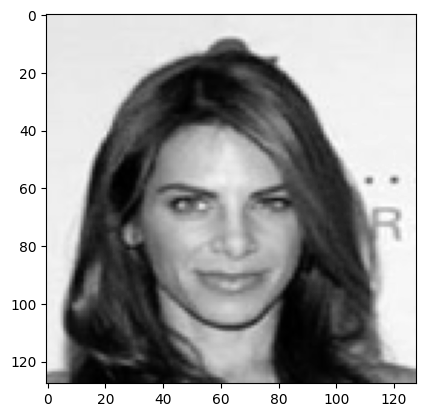

In [209]:
mon_batch = next(iter(train_separe))
ma_celeb_L = mon_batch[0][0]
ma_celeb_ab = mon_batch[1][0]
plt.imshow(ma_celeb_L, cmap="gray")

In [210]:
def rassembler_L_et_ab(L, ab):
    a = ab[:,:,0]
    b = ab[:,:,0]
    return skimage.color.lab2rgb(np.stack([L, a, b], axis=2))

def rassembler_L_et_ab_tensor(L_tensor, ab_tensor):
    L_numpy = L_tensor.numpy()
    ab_numpy = ab_tensor.numpy()
    rgb_numpy = rassembler_L_et_ab(L_numpy, ab_numpy)
    return tf.convert_to_tensor(rgb_numpy)

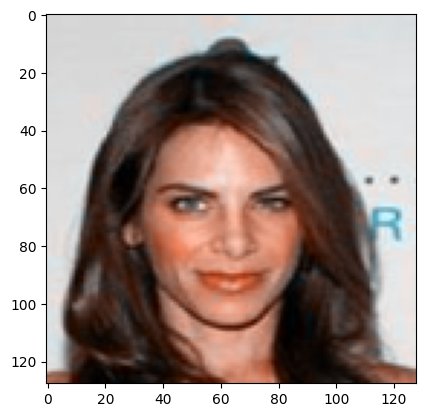

In [211]:
plt.imshow(rassembler_L_et_ab_tensor(ma_celeb_L, ma_celeb_ab))

In [216]:
ma_celeb_ab_predict = reseau.predict(tf.convert_to_tensor([ma_celeb_L]), batch_size =1)[0,:,:,:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [217]:
ma_celeb_ab_predict.shape

(128, 128, 2)

/tmp/ipykernel_5329/2028043554.py:4: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 123 negative Z values that have been clipped to zero
  return skimage.color.lab2rgb(np.stack([L, a, b], axis=2))


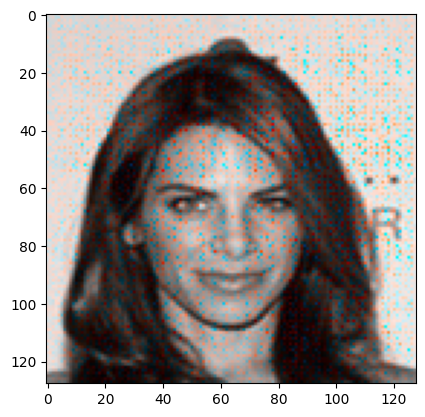

In [218]:
plt.imshow(rassembler_L_et_ab_tensor(ma_celeb_L, tf.convert_to_tensor(ma_celeb_ab_predict*1000)))

In [ ]:
reseau.compile(optimizer="adam",
               loss="mse")

reseau.fit(train_separe, epochs=5)

Epoch 1/5
      8/Unknown 7s 551ms/step - loss: 215.3023

KeyboardInterrupt: 